In [11]:
import os
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torchvision.transforms.functional as TF
from gradcam.utils.image import show_cam_on_image
from gradcam.student_cam import ActionErrTarget, StudentCAM, ActionTarget
from pipelines.models.student import StudentPolicy

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [12]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
device = torch.device('cuda')

In [13]:
DOMAINS = ['rgb']

student_save_path = flightmare_path / "flightpy/snaga_results/students/teacher_PPO_25/multivit_02-18-14-43-24"
model_cfg_path = student_save_path / "config_model.yaml"
model_config = yaml.safe_load(open(model_cfg_path, "r"))
model_name = list(model_config.keys())[0] 
student_policy = StudentPolicy(model_config, model_name)

saved_model_path = student_save_path / "model/multivit_ep063_gp_7.25_vl_0.00_10009984.pth"
saved_variables = torch.load(saved_model_path, map_location=device)
student_policy.load_state_dict(saved_variables["state_dict"], strict=True)
student_policy.to(device)
print(f"Load student policy's weights from {saved_model_path}")

Load student policy's weights from /home/chunwei/Documents/drone_offboard/flightmare_internal/flightpy/snaga_results/students/teacher_PPO_25/multivit_02-18-14-43-24/model/multivit_ep063_gp_7.25_vl_0.00_10009984.pth


In [14]:
# Pre-process RGB, depth and semseg to the MultiMAE input format

rgb_imgs, depth_imgs, semseg_imgs = [], [], []
image_floats = []

for i in range(8):
    
    step = 62 + i
    prefix = f"step_0000{step}_"
    print(f"Processing sample {step}...")
    
    multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"
    sample_rgb = multimae_path / f"samples/{prefix}rgb.png"
    sample_depth = multimae_path / f"samples/{prefix}depth.npy"
    sample_semseg = multimae_path / f"samples/{prefix}semseg.png"
    sample_label = multimae_path / f"samples/{prefix}label.npz"
    
    image = cv2.imread(str(sample_rgb))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_float = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
    c, h, w = image_float.shape

    image_float = TF.center_crop(image_float, min([h, w]))
    image_float = TF.resize(image_float, 224)
    image_float = image_float.permute(1, 2, 0).numpy().astype(np.float32)
    image_floats.append(image_float)

    image = Image.fromarray(image)

    semseg = cv2.imread(str(sample_semseg))
    depth = np.load(str(sample_depth))

    rgb_imgs.append(np.expand_dims(image, [0, -1]))
    depth_imgs.append(np.expand_dims(depth, [0, -1]))
    semseg_imgs.append(np.expand_dims(semseg[:, :, 0], [0, 3, 4]))

rgb_imgs = np.concatenate(rgb_imgs, axis=-1)
depth_imgs = np.concatenate(depth_imgs, axis=-1)
semseg_imgs = np.concatenate(semseg_imgs, axis=-1)

input_dict = {
    "rgb": rgb_imgs,
    "depth": depth_imgs,
    "semseg": semseg_imgs
}
inputs = {k: torch.from_numpy(input_dict[k]) for k in DOMAINS}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

Processing sample 62...
Processing sample 63...
Processing sample 64...
Processing sample 65...
Processing sample 66...
Processing sample 67...
Processing sample 68...
Processing sample 69...
(1, 480, 640, 3, 8)
(1, 480, 640, 1, 8)
(1, 480, 640, 1, 8)


In [15]:
torch.manual_seed(1) # change seed to resample new mask
num_encoded_tokens = 196 # the number of visible tokens
alphas = 1.0 # Dirichlet concentration parameter

In [16]:
student_action = student_policy(inputs, require_grad=True, input_data_format="embed")
print(student_action.cpu().detach().numpy())

[[ 0.98775727  0.07738534  0.18181574 -0.00837031]]


In [17]:
state_inputs = np.load(multimae_path / "samples/step_000062.npz")

In [18]:
target_layers = [student_policy.embedding_layer.vit_model.encoder[-1].norm1]
action_label = torch.from_numpy(state_inputs["act"]).float().to(device)
targets = [ActionTarget()]

cam = StudentCAM(model=student_policy,
                  target_layers=target_layers,
                  use_cuda=True)

grayscale_cam = cam(input_tensor=inputs, 
                    targets=targets, 
                    # inputs for the student policy
                    require_grad=True, 
                    input_data_format="embed"
                    )
print(grayscale_cam.shape)

(8, 224, 224)


(-0.5, 639.5, 479.5, -0.5)

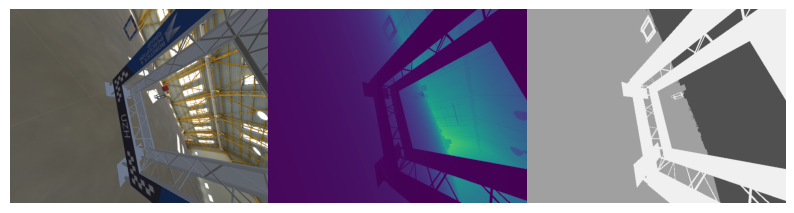

In [19]:
fig = plt.figure(figsize=(10, 10))
axs = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0)

axs[0].imshow(image)
axs[0].axis('off')
axs[1].imshow(depth)
axs[1].axis('off')
axs[2].imshow(semseg * 80)       
axs[2].axis('off')                                                                                                  

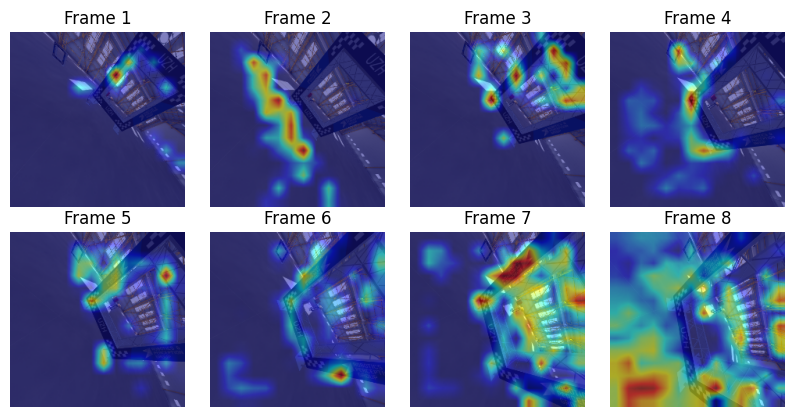

In [20]:
fig = plt.figure(figsize=(10, 10))
axs = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.25)

for i in range(8):
    cam_image = show_cam_on_image(image_floats[i], grayscale_cam[i, :, :], use_rgb=True)
    axs[i].imshow(cam_image)
    axs[i].axis('off')
    axs[i].set_title(f"Frame {i+1}")